In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
from torchvision import datasets
from torchvision import transforms

data_path = "../lesson3/dataset"
# cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
# cifar10 = datasets.CIFAR10(data_path, train=False, download=True)
cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)),
        ]
    ),
)

cifar10_val = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)),
        ]
    ),
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
label_map = {0: 0, 2: 1}
class_names = ["airplane", "bird"]
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [4]:
import torch.nn as nn

n_out = 2
model = nn.Sequential(nn.Linear(3072, 512), nn.Tanh(), nn.Linear(512, n_out))

In [5]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [6]:
x = torch.tensor([1.0, 2.0, 3.0])
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [7]:
softmax(x).sum()

tensor(1.)

In [8]:
softmax = nn.Softmax(dim=1)
x = torch.tensor([[1.0, 2.0, 3.0], [3.0, 4.0, 5.0]])
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [9]:
import torch.nn as nn

n_out = 2
model = nn.Sequential(
    nn.Linear(3072, 512), nn.Tanh(), nn.Linear(512, n_out), nn.Softmax(dim=1)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


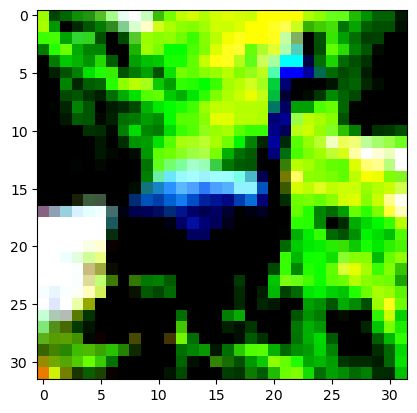

In [10]:
img, _ = cifar2[0]
plt.imshow(img.permute(1, 2, 0))

In [11]:
img.shape

torch.Size([3, 32, 32])

img.view(-1): Flattens the tensor.
unsqueeze(0): Adds a batch dimension (resulting in a shape like [1, N], where N is the total number of elements in the original tensor).


In [12]:
img_batch = img.view(-1).unsqueeze(0)
img_batch.shape

torch.Size([1, 3072])

In [13]:
img_batch2 = img.unsqueeze(0)
img_batch2.shape

torch.Size([1, 3, 32, 32])

In [14]:
out = model(img_batch)
out

tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward0>)

In [15]:
_, index = torch.max(out, dim=1)
index

tensor([1])

In [16]:
out = torch.tensor(
    [
        [0.6, 0.4],
        [0.9, 0.1],
        [0.3, 0.7],
        [0.2, 0.8],
    ]
)

class_index = torch.tensor([0, 0, 1, 1]).unsqueeze(1)
class_index
truth = torch.zeros((4, 2))
truth
truth.scatter_(dim=1, index=class_index, value=1.0)
truth

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

In [17]:
def mse(out):
    return ((out - truth) ** 2).sum(dim=1).mean()
    # y = (out - truth) ** 2
    # print(y)


mse(out)

tensor(0.1500)

In [18]:
out.gather(dim=1, index=class_index)

tensor([[0.6000],
        [0.9000],
        [0.7000],
        [0.8000]])

In [19]:
def likelihood(out):
    prod = 1.0
    for x in out.gather(dim=1, index=class_index):

        prod *= x

    return prod


likelihood(out)

tensor([0.3024])

In [20]:
def neg_log_likelihood(out):
    return -likelihood(out).log()


neg_log_likelihood(out)

tensor([1.1960])

In [21]:
out

tensor([[0.6000, 0.4000],
        [0.9000, 0.1000],
        [0.3000, 0.7000],
        [0.2000, 0.8000]])

In [22]:
out0 = out.clone().detach()
out0[0] = torch.tensor([0.9, 0.1])
out2 = out.clone().detach()
out2[0] = torch.tensor([0.4, 0.6])
out3 = out.clone().detach()
out3[0] = torch.tensor([0.1, 0.9])

mse_comparison = torch.tensor([mse(o) for o in [out0, out, out2, out3]])
mse_comparison

tensor([0.0750, 0.1500, 0.2500, 0.4750])

In [23]:
for o in [out0, out, out2, out3]:
    print(o)
    mse(o)
    print(mse(o))

tensor([[0.9000, 0.1000],
        [0.9000, 0.1000],
        [0.3000, 0.7000],
        [0.2000, 0.8000]])
tensor(0.0750)
tensor([[0.6000, 0.4000],
        [0.9000, 0.1000],
        [0.3000, 0.7000],
        [0.2000, 0.8000]])
tensor(0.1500)
tensor([[0.4000, 0.6000],
        [0.9000, 0.1000],
        [0.3000, 0.7000],
        [0.2000, 0.8000]])
tensor(0.2500)
tensor([[0.1000, 0.9000],
        [0.9000, 0.1000],
        [0.3000, 0.7000],
        [0.2000, 0.8000]])
tensor(0.4750)


In [24]:
((mse_comparison / mse_comparison[1]) - 1) * 100

tensor([-50.0000,   0.0000,  66.6667, 216.6667])

In [25]:
nll_comparison = torch.tensor([neg_log_likelihood(o) for o in [out0, out, out2, out3]])
nll_comparison

tensor([0.7905, 1.1960, 1.6015, 2.9878])

In [26]:
((nll_comparison / nll_comparison[1]) - 1) * 100

tensor([-33.9016,   0.0000,  33.9016, 149.8121])

In [27]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

softmax(x)

tensor([[0., 1.]])

In [28]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

log_softmax(x)

tensor([[-104.,    0.]])

In [29]:
torch.log(softmax(x))

tensor([[-inf, 0.]])

In [30]:
torch.exp(log_softmax(x))

tensor([[0., 1.]])

In [31]:
model = nn.Sequential(
    nn.Linear(3072, 512), nn.Tanh(), nn.Linear(512, 2), nn.LogSoftmax(dim=1)
)
loss = nn.NLLLoss()
img, label = cifar2[0]

out = model(img.view(-1).unsqueeze(0))

loss(out, torch.tensor([label]))

tensor(0.5077, grad_fn=<NllLossBackward0>)

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim

mdoel = nn.Sequential(
    nn.Linear(3072, 512), nn.Tanh(), nn.Linear(512, 2), nn.LogSoftmax(dim=1)
)

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch : %d, LOss : %f" % (epoch, float(loss)))

Epoch : 0, LOss : 2.808479
Epoch : 1, LOss : 2.832569
Epoch : 2, LOss : 5.176270
Epoch : 3, LOss : 5.776686
Epoch : 4, LOss : 3.877132
Epoch : 5, LOss : 2.053756
Epoch : 6, LOss : 9.040649
Epoch : 7, LOss : 9.483339
Epoch : 8, LOss : 14.036193
Epoch : 9, LOss : 6.748063
Epoch : 10, LOss : 10.453506
Epoch : 11, LOss : 7.707525
Epoch : 12, LOss : 11.678914
Epoch : 13, LOss : 2.176284
Epoch : 14, LOss : 11.310536
Epoch : 15, LOss : 8.300934
Epoch : 16, LOss : 9.714619
Epoch : 17, LOss : 16.265474
Epoch : 18, LOss : 15.884706
Epoch : 19, LOss : 6.464939
Epoch : 20, LOss : 6.790210
Epoch : 21, LOss : 11.052434
Epoch : 22, LOss : 10.355342
Epoch : 23, LOss : 1.387925
Epoch : 24, LOss : 7.006418
Epoch : 25, LOss : 3.956246
Epoch : 26, LOss : 3.005236
Epoch : 27, LOss : 8.344983
Epoch : 28, LOss : 5.165214
Epoch : 29, LOss : 13.271230
Epoch : 30, LOss : 9.225438
Epoch : 31, LOss : 2.415284
Epoch : 32, LOss : 11.242496
Epoch : 33, LOss : 11.464164
Epoch : 34, LOss : 3.139958
Epoch : 35, LOss : 

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
mdoel = nn.Sequential(
    nn.Linear(3072, 128), nn.Tanh(), nn.Linear(128, 2), nn.LogSoftmax(dim=1)
)

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100

for epoch in range(n_epochs):
    for img, label in train_loader:
        out = model(img.view(img.shape[0], -1))
        loss = loss_fn(out, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch : %d, Loss : %f" % (epoch, float(loss)))

Epoch : 0, Loss : 0.038185
Epoch : 1, Loss : 0.699414
Epoch : 2, Loss : 0.266586
Epoch : 3, Loss : 0.512294
Epoch : 4, Loss : 0.080110
Epoch : 5, Loss : 0.104072
Epoch : 6, Loss : 0.720311
Epoch : 7, Loss : 0.330848
Epoch : 8, Loss : 0.078129
Epoch : 9, Loss : 0.561766
Epoch : 10, Loss : 0.053830
Epoch : 11, Loss : 0.486638
Epoch : 12, Loss : 0.979982
Epoch : 13, Loss : 0.242778
Epoch : 14, Loss : 0.185047
Epoch : 15, Loss : 0.386388
Epoch : 16, Loss : 0.102807
Epoch : 17, Loss : 0.153656
Epoch : 18, Loss : 0.430645
Epoch : 19, Loss : 0.245167
Epoch : 20, Loss : 0.311532
Epoch : 21, Loss : 0.388422
Epoch : 22, Loss : 0.114615
Epoch : 23, Loss : 0.032254
Epoch : 24, Loss : 0.634145
Epoch : 25, Loss : 0.351809
Epoch : 26, Loss : 0.022452
Epoch : 27, Loss : 0.367552
Epoch : 28, Loss : 0.134817
Epoch : 29, Loss : 0.371300
Epoch : 30, Loss : 0.109281
Epoch : 31, Loss : 0.069391
Epoch : 32, Loss : 0.088064
Epoch : 33, Loss : 0.057636
Epoch : 34, Loss : 0.016943
Epoch : 35, Loss : 0.042883
Ep

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
mdoel = nn.Sequential(
    nn.Linear(3072, 512), nn.Tanh(), nn.Linear(512, 2), nn.LogSoftmax(dim=1)
)

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100

for epoch in range(n_epochs):
    for img, label in train_loader:
        out = model(img.view(img.shape[0], -1))
        loss = loss_fn(out, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch : %d, Loss : %f" % (epoch, float(loss)))

Epoch : 0, Loss : 0.018014
Epoch : 1, Loss : 0.018784
Epoch : 2, Loss : 0.129459
Epoch : 3, Loss : 0.097997
Epoch : 4, Loss : 0.083308
Epoch : 5, Loss : 0.113809
Epoch : 6, Loss : 0.094995
Epoch : 7, Loss : 0.214036
Epoch : 8, Loss : 0.168420
Epoch : 9, Loss : 0.568595
Epoch : 10, Loss : 0.106334
Epoch : 11, Loss : 0.072342
Epoch : 12, Loss : 0.060347
Epoch : 13, Loss : 0.071979
Epoch : 14, Loss : 0.055378
Epoch : 15, Loss : 0.006275
Epoch : 16, Loss : 0.073337
Epoch : 17, Loss : 0.208315
Epoch : 18, Loss : 0.118850
Epoch : 19, Loss : 0.086371
Epoch : 20, Loss : 0.399874
Epoch : 21, Loss : 0.276818
Epoch : 22, Loss : 0.305124
Epoch : 23, Loss : 0.067572
Epoch : 24, Loss : 0.269500
Epoch : 25, Loss : 0.044284
Epoch : 26, Loss : 0.091967
Epoch : 27, Loss : 0.257409
Epoch : 28, Loss : 0.029445
Epoch : 29, Loss : 0.571882
Epoch : 30, Loss : 0.156887
Epoch : 31, Loss : 0.037059
Epoch : 32, Loss : 0.172665
Epoch : 33, Loss : 0.145956
Epoch : 34, Loss : 0.085551
Epoch : 35, Loss : 0.205276
Ep

In [35]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        print(total, labels)
        correct += int((predicted == labels).sum())
print("Accuracy: %f" % (correct / total))

64 tensor([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
        1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0])
128 tensor([0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0])
192 tensor([1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0])
256 tensor([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0])
320 tensor([0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 1, 1

In [36]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f" % (correct / total))

Accuracy: 0.752500


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.497427
Epoch: 1, Loss: 0.615837
Epoch: 2, Loss: 0.436824
Epoch: 3, Loss: 0.347781
Epoch: 4, Loss: 0.577657
Epoch: 5, Loss: 0.411738
Epoch: 6, Loss: 0.508799
Epoch: 7, Loss: 0.461894
Epoch: 8, Loss: 0.512662
Epoch: 9, Loss: 0.538019
Epoch: 10, Loss: 0.169521
Epoch: 11, Loss: 0.142382
Epoch: 12, Loss: 0.742934
Epoch: 13, Loss: 0.645561
Epoch: 14, Loss: 0.776193
Epoch: 15, Loss: 0.387493
Epoch: 16, Loss: 0.332133
Epoch: 17, Loss: 0.302807
Epoch: 18, Loss: 0.791955
Epoch: 19, Loss: 0.145664
Epoch: 20, Loss: 0.198251
Epoch: 21, Loss: 0.401624
Epoch: 22, Loss: 0.078391
Epoch: 23, Loss: 0.232259
Epoch: 24, Loss: 0.142118
Epoch: 25, Loss: 0.523029
Epoch: 26, Loss: 0.368597
Epoch: 27, Loss: 0.216721
Epoch: 28, Loss: 0.712369
Epoch: 29, Loss: 0.253066
Epoch: 30, Loss: 0.096683
Epoch: 31, Loss: 0.276528
Epoch: 32, Loss: 0.082747
Epoch: 33, Loss: 0.232660
Epoch: 34, Loss: 0.274998
Epoch: 35, Loss: 0.205447
Epoch: 36, Loss: 0.057985
Epoch: 37, Loss: 0.108904
Epoch: 38, Loss: 0.190

In [38]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f" % (correct / total))

Accuracy: 1.000000


In [39]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f" % (correct / total))

Accuracy: 0.809000


In [40]:
sum([p.numel() for p in model.parameters()])

3737474

In [41]:
sum([p.numel() for p in model.parameters() if p.requires_grad == True])

3737474

In [42]:
linear = nn.Linear(3072, 1024)
linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [43]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv.weight.shape

torch.Size([16, 3, 3, 3])

In [44]:
conv.bias.shape

torch.Size([16])

In [45]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))

In [46]:
img.unsqueeze(0)

tensor([[[[ 0.6139, -0.3228,  ..., -0.2752, -0.5451],
          [ 0.6615, -0.1482,  ..., -0.3228, -0.5768],
          ...,
          [ 0.5980,  0.4393,  ..., -0.4340,  0.0265],
          [ 0.9156,  0.8044,  ..., -0.5451, -0.0529]],

         [[ 1.3369,  0.2740,  ...,  0.3867,  0.0968],
          [ 1.4497,  0.5961,  ...,  0.3062,  0.0646],
          ...,
          [ 0.5478,  0.6605,  ...,  0.4028,  0.8860],
          [ 0.4834,  0.9504,  ...,  0.1613,  0.7572]],

         [[-0.4487, -0.7935,  ..., -0.6736, -0.8535],
          [-0.4487, -0.9734,  ..., -0.6286, -0.8535],
          ...,
          [-0.4337, -0.4787,  ..., -1.3032, -0.9884],
          [-0.1789,  0.0310,  ..., -1.3182, -1.0484]]]])

In [47]:
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


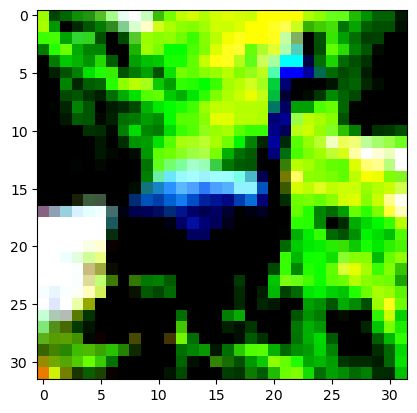

In [48]:
plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.show()

detach():
This removes the tensor from the computational graph (used in PyTorch), meaning the tensor is no longer connected to the computation of gradients. This is necessary if output is the result of a forward pass in a neural network and you're only interested in displaying the image without computing further gradients.


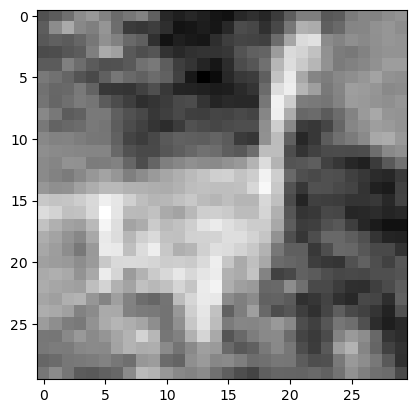

In [49]:
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

In [50]:
out.shape

torch.Size([16, 2])

In [51]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))

output.shape

torch.Size([1, 1, 32, 32])

In [52]:
with torch.no_grad():
    conv.bias.zero_()

In [53]:
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

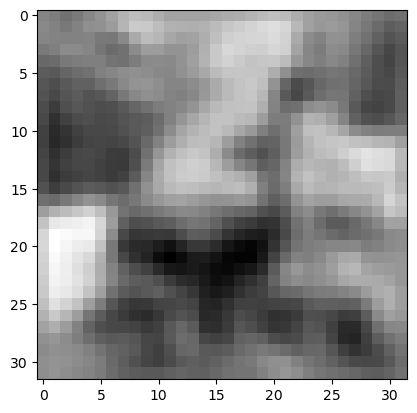

In [54]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

In [55]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor(
        [[-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0]]
    )
    conv.bias.zero_()

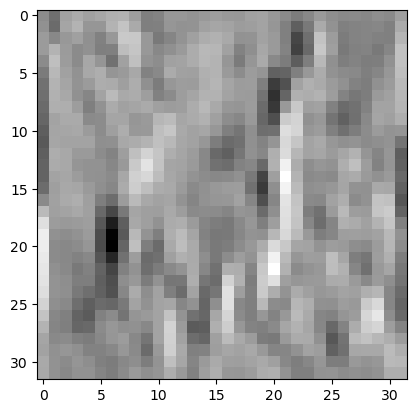

In [56]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

In [57]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

output.shape

torch.Size([1, 3, 16, 16])

In [58]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
)

In [59]:
import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),  # Layer 1
    nn.Tanh(),  # Activation 1
    nn.MaxPool2d(2),  # Pooling 1
    nn.Conv2d(16, 8, kernel_size=3, padding=1),  # Layer 2
    nn.Tanh(),  # Activation 2
    nn.MaxPool2d(2),  # Pooling 2
    nn.Flatten(),  # Flatten layer (Added)
    nn.Linear(512, 32),  # Fully Connected Layer 1
    nn.Tanh(),  # Activation 4
    nn.Linear(32, 2),  # Fully Connected Layer 2
)

In [60]:
sum([p.numel() for p in model.parameters()])

18090

In [61]:
model(img.unsqueeze(0))

tensor([[-0.1522,  0.1896]], grad_fn=<AddmmBackward0>)

In [62]:
import torch.nn as nn


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        return self.fc2(out)

In [63]:
model = Net()

sum(p.numel() for p in model.parameters())

18090

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)


class Net(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Net, self).__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


model = Net()
learning = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs
for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.625103
Epoch: 1, Loss: 0.330666
Epoch: 2, Loss: 0.463030
Epoch: 3, Loss: 0.459484
Epoch: 4, Loss: 0.249857
Epoch: 5, Loss: 0.481206
Epoch: 6, Loss: 0.583047
Epoch: 7, Loss: 0.610404
Epoch: 8, Loss: 0.230814
Epoch: 9, Loss: 0.419008
Epoch: 10, Loss: 0.438193
Epoch: 11, Loss: 0.193210
Epoch: 12, Loss: 0.148880
Epoch: 13, Loss: 0.158207
Epoch: 14, Loss: 0.612842
Epoch: 15, Loss: 0.449868
Epoch: 16, Loss: 0.155404
Epoch: 17, Loss: 0.242829
Epoch: 18, Loss: 0.312775
Epoch: 19, Loss: 0.170020
Epoch: 20, Loss: 0.298276
Epoch: 21, Loss: 0.466996
Epoch: 22, Loss: 0.596681
Epoch: 23, Loss: 0.296458
Epoch: 24, Loss: 0.239476
Epoch: 25, Loss: 0.586413
Epoch: 26, Loss: 0.222544
Epoch: 27, Loss: 0.321402
Epoch: 28, Loss: 0.237620
Epoch: 29, Loss: 0.337007
Epoch: 30, Loss: 0.580622
Epoch: 31, Loss: 0.183228
Epoch: 32, Loss: 0.519659
Epoch: 33, Loss: 0.297368
Epoch: 34, Loss: 0.140327
Epoch: 35, Loss: 0.191947
Epoch: 36, Loss: 0.114817
Epoch: 37, Loss: 0.225188
Epoch: 38, Loss: 0.308

In [66]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
print("Accuracy: %f" % (correct / total))

Accuracy: 0.952800


In [69]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
print("Accuracy : %.f " % (correct / total))

Accuracy : 1 


In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


model = Net()
sum([p.numel() for p in model.parameters()])

18090

In [73]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2),
)

model(img.unsqueeze(0))

tensor([[-0.0058,  0.1444]], grad_fn=<AddmmBackward0>)